# Matche Amazon-Produkte (DVDs) mit Wikipedia-Artikeln

Autor: Christian Koss - ckoss@uni-bremen.de

Um die Amazon-Artikel mit den zugehörigen Wikipedia-Artikeln zu matchen, müssten 18920*6203084 Vergleiche durchgeführt werden. Viel zu viel!

Es wurde daher zuvor die möglichen Wikipedia-Artikel über die Variable "Infobox" eingegrenzt.

In [1]:
# Verwendete externe Packages
import pandas as pd
import sqlite3
import re
from collections import Counter
import Levenshtein

In [2]:
wikipedia_sql='data/wikipedia/infobox.db'
amazon_sql='data/amazon/amazon.db'

In [3]:
# Lade Wiki-Titel
conn=sqlite3.connect(wikipedia_sql)
cur = conn.cursor()
cur.execute('SELECT ID, title, originaltitel, infobox FROM infobox')
data=cur.fetchall()

wiki_raw=dict((ID, [title, originaltitel, info]) for ID, title, originaltitel, info in data)
wiki_title=dict((title, ID) for ID,title, originaltitel, info in data)
wiki_title=dict((title, ID) for ID,title, originaltitel, info in data)

wiki_dirty=dict((re.sub('[^A-Za-z]','',title.lower()), ID) for ID, title, originaltitel, info in data)

conn.close()
print(len(wiki_raw), len(wiki_title), '\n',data[0])

43787 43787 
 ('177121967', 'Welt am Draht', 'Welt am Draht', 'Film')


In [4]:
# Lade Amazon-Titel
conn=sqlite3.connect(amazon_sql)
cur = conn.cursor()
cur.execute("SELECT asin, title FROM dvd")
data=cur.fetchall()
amaz_raw=dict((k, v) for k,v in data)
amaz_title=dict((v, k) for k,v in data)

conn.close()
len(amaz_raw),len(amaz_title), data[0]

#Gleiche Titel mit verschiedenen asin!

(18920,
 18367,
 ('B002GH1M5W',
  'X-Men Origins: Wolverine (Extended Version inkl. Digital Copy)'))

# Phase 1: Naive Matches

In [5]:
# Beispiel:
title=re.sub('\(.*?\)','',data[0][1]).strip()
data[0][1], wiki_title[title], wiki_raw[wiki_title[title]]

('X-Men Origins: Wolverine (Extended Version inkl. Digital Copy)',
 '180033149',
 ['X-Men Origins: Wolverine', 'X Men Origins Wolverine', 'Film'])

In [6]:
# phase 1: naiver Match
matched={}
amaz=amaz_raw.copy()
unmatched=amaz.copy()

example={}

kategorien=['Film','Fernsehsendung','Comic','Anime','Anime-Fernsehserie','Anime-Filme','Oper']

for key, value in unmatched.items():
    match=False
    
    value=value.replace('&amp;','&')
        
        
    #exakter Match mit Zusatz
    if match==False:
        for zusatz in kategorien:
            try:
                temp=value+' ('+zusatz+')'
                matched[key]=wiki_raw[wiki_title[temp]]
                match=True
                break;
            except:
                match=False

            #ohne Untertitel mit Zusatz
            if match==False:
                try:
                    temp=re.sub('\(.*?\)','', value)
                    temp=re.sub('\[.*?\]','', temp)
                    temp=temp.split('-')[0].split(':')[0].split('/')[0].strip()
                    temp=temp+' ('+zusatz+')'
                    matched[key]=wiki_raw[wiki_title[temp]]
                    match=True
                    break;
                except:
                    match=False
      
    #exakter Match
    if match==False:
        try:
            temp=value
            matched[key]=wiki_raw[wiki_title[temp]]
            match=True
        except:
            match=False
        
    #ohne Klammern
    if match==False:
        try:
            temp=re.sub('\(.*?\)','', value).strip()
            matched[key]=wiki_raw[wiki_title[temp]]
            match=True
        except:
            match=False
            
    #ohne Untertitel
    if match==False:
        try:
            temp=re.sub('\(.*?\)','', value)
            temp=re.sub('\[.*?\]','', temp)
            temp=temp.split('-')[0].split(':')[0].split('/')[0].strip()
            matched[key]=wiki_raw[wiki_title[temp]]
            match=True
        except:
            match=False
            
    #dirty - nur Buchstaben
    if match==False:
        try:
            temp=re.sub('\(.*?\)','', value)
            temp=re.sub('\[.*?\]','', temp)
            temp=re.sub('[^A-Za-z]','',temp.lower())
            matched[key]=wiki_raw[wiki_dirty[temp]]
            temp=wiki_raw[wiki_dirty[temp]][0]
            match=True
        except:
            match=False
            
    #dirty2 - nur Buchstaben, ohne Untertitel
    if match==False:
        try:
            temp=re.sub('\(.*?\)','', value)
            temp=re.sub('\[.*?\]','', temp).split('-')[0].split(':')[0].split('.')[0].split('/')[0].strip()
            temp=re.sub('[^A-Za-z]','',temp.lower())
            matched[key]=wiki_raw[wiki_dirty[temp]]
            temp=wiki_raw[wiki_dirty[temp]][0]
            match=True
        except:
            match=False
        
    #speichere Anzahl der "info" und ein Beispiel-Titel
    if match==True:
        amaz.pop(key, None)
        try:
            value=temp
            temp=example[wiki_raw[wiki_title[value]][2]]
            example[wiki_raw[wiki_title[value]][2]]=(temp[0]+1,temp[1])
        except:
            example[wiki_raw[wiki_title[value]][2]]=(1,value)
            
unmatched=amaz.copy()

print(str(len(matched))+"/"+str(len(amaz_raw)))

10263/18920


In [7]:
sorted(example.items(), key=lambda x: x[1][0], reverse=True)[:20]

[('Film', (8803, 'Blutspur (1979)')),
 ('Fernsehsendung', (1286, 'Dall-As')),
 ('Comic', (63, 'Black Cat')),
 ('Anime-Fernsehserie', (58, 'Dragon Ball Z')),
 ('Oper', (53, 'Luther (Oper)'))]

# Phase 2: Wahrscheinlichkeits-Match

In [8]:
# Phase 2: Wahrscheinlichkeits-Match

# Lade Wiki-Titel
conn=sqlite3.connect(wikipedia_sql)
cur = conn.cursor()
cur.execute('SELECT ID, title, originaltitel, infobox FROM infobox')
wiki=cur.fetchall()
conn.close()
print('Anzahl der Wikipedia-Artikel zu den gewählten Kategorien: ',len(wiki))
print('Beispiel:',wiki[0])

Anzahl der Wikipedia-Artikel zu den gewählten Kategorien:  43787
Beispiel: ('177121967', 'Welt am Draht', 'Welt am Draht', 'Film')


In [9]:
# Deutsche und Originale Titel
de_titel=[(ID, dt, info) for ID, dt, ot, info in wiki]
original_titel=[(ID, ot, info) for ID, dt, ot, info in wiki]
wiki=sorted(list(set(de_titel+original_titel)))

In [10]:
# Untersuche häufige Wörter in Amazon-Titelb
tokens=re.findall('[^\s]+',' '.join([title for ID,title in amaz.items()]))
print(Counter(tokens).most_common(100))

[('-', 5614), ('DVDs)', 1346), ('The', 1035), ('Die', 1003), ('Live', 588), ('der', 588), ('(2', 547), ('[UK', 440), ('Der', 433), ('Import]', 420), ('in', 410), ('2', 409), ('&amp;', 407), ('of', 364), ('und', 350), ('1', 341), ('the', 334), ('(3', 306), ('Staffel', 278), ('Vol.', 271), ('Das', 248), ('[Blu-ray]', 242), ('Collection', 227), ('(4', 205), ('des', 200), ('Edition', 198), ('Season', 193), ('komplette', 186), ('DVD', 175), ('/', 173), ('In', 162), ('mit', 155), ('Box', 150), ('+', 142), ('3', 142), ('die', 137), ('im', 131), ('von', 131), ('Teil', 125), ('4', 116), ('at', 116), ('Of', 105), ('(6', 102), ('Edition,', 102), ('A', 100), ('(Special', 100), ('für', 99), ('Best', 98), ('Edition)', 98), ('Concert', 95), ('(NTSC)', 93), ('Various', 93), ('Artists', 92), ('and', 91), ('Tour', 88), ('(5', 88), ('auf', 80), ('Complete', 78), ('Series', 77), ('aus', 76), ('At', 76), ('Welt', 75), ('Ein', 74), ('(OmU)', 72), ('DVDs', 70), ('Im', 67), ('dem', 65), ('WWE', 62), ('Night',

In [11]:
# Untersuche häufige Signalwörter bezüglich Serien
for a,b in amaz.items():
    temp= b.split('-')[0]
    if 'Staffel' in temp or 'Serie' in temp  or 'Season' in temp:
        print(b)

The 4400 Season 4
Charmed komplette Staffeln 1-8 (48DVDs) Limited Edition
Life on Mars: Series 1 &amp; 2 Complete Boxset [UK IMPORT]
O.C. California Die komplette Serie ( Superbox)
Moselbrück Staffel 2, Episode 11-20 (3 Disc Set)
Quincy Season 1 + 2 (5 DVDs)
The Mentalist Die komplette erste Staffel (6 DVDs)
Ein Käfig voller Helden Staffel 1 in Munitionskiste mit T-Shirt - exklusiv bei Amazon.de (limitiert auf 2500 Stück)
Die Schwarzwaldklinik, Staffel 4 (4 DVDs)
Die Schwarzwaldklinik, Staffel 5 (4 DVDs)
Hercules Staffel 1
Veronica Mars Die komplette Serie (Superbox)
Power Rangers In Space (Complete Season)
Star Wars: The Clone Wars, Vol. 1: Geteilte Galaxie (Staffel 1)
Serien-Killer Hautnah + Dead Man Talking ( Double Feature )
Friends Superbox (Staffeln 1 bis 10) (41 DVDs)
MacGyver Staffel 1 (mit original Messer, limitiert auf 3000 Stück, exklusiv bei Amazon.de)
Dexter Season 1
Bones: Season 3 (4 DVDs)
King of Queens  IPS Superbox (Staffel 1-9 komplett, 36 DVDs)
Kommissar Rex Staffel

In [12]:
wiki[0]

('105838823', 'Amerika s Atom Bomb Tests', 'Film')

In [13]:
matches=[]
count=0

for dvd in amaz_raw.items():
    simil=[]
    titled=dvd[1].replace('Die besten Filme aller Zeiten','').strip()
    if 'Staffel' in titled or 'Serie' in titled  or 'Season' in titled:
        if 'Bee Season' not in titled or 'Serien-Killer' not in titled or '(Platinum Serie)' not in titled or 'Serienwahn' not in titled:
            titled+=' (Fernsehsendung)'

    for film in wiki:
        titlew=film[1]
        info=film[2]
        
         # ohne Slash
        prob=Levenshtein.ratio(titled.split('/')[0].strip(), titlew)
        simil.append((film,str(prob)[:4]))
        
        # split "mit" (z.B. Indiana Jones mit Harrison Ford)
        prob=Levenshtein.ratio(titled.split(' mit')[0].strip(), titlew)
        simil.append((film,str(prob)[:4]))
        
        # ohne Untertitel
        prob=Levenshtein.ratio(titled.replace('–','-').split('-')[0].strip(), titlew)
        simil.append((film,str(prob)[:4]))
        
        # ohne Untertitel2
        prob=Levenshtein.ratio(titled.split(':')[0].strip(), titlew)
        simil.append((film,str(prob)[:4]))
        
        if info not in titlew:
            titlew+=' ('+info+')'
        prob=Levenshtein.ratio(titled,titlew)        
        simil.append((film,str(prob)[:4]))
        
        
        #cleaning
        c_titled=re.sub('\(.*?\)','',titled).lower()
        c_titled=re.sub('\[.*?\]','',c_titled)
        for rep in ["""'s""",'episoden','episode','das','die','der','trilogy','ultimate','special','limited','edition','collection','collectors','collector','staffel','serie','season','dvds','dvd','vol.','complete','boxset','box','live','&amp;']:
            c_titled=c_titled.replace(rep,'')
           
        temp0=c_titled
        
        c_titled=re.sub('[^a-z]','',c_titled)        
        c_titlew=re.sub('\(.*?\)','',titlew).lower()
        c_titlew=re.sub('\[.*?\]','',c_titlew)
        
        temp=c_titlew
        
        c_titlew=re.sub('[^a-z]','',c_titlew)
        for rep in ["""'s""",'das','die','der']:
            c_titlew=c_titlew.replace(rep,'')
        
        prob=Levenshtein.ratio(c_titled.strip(),c_titlew.strip())
        simil.append((film,str(prob)[:4]))
        
        #match reiner Untertitel
        temp=temp.replace('-','–')
        temp=re.sub('\(.*?\)','',temp).lower()
        if '–' in temp:
            c_titlewsub=temp.split('–',1)[-1]
            c_titlew=re.sub('[^a-z]','',c_titlewsub)
            for rep in ["""'s""",'das','die','der']:
                c_titlew=c_titlew.replace(rep,'')
            prob=Levenshtein.ratio(c_titled.strip(),c_titlew.strip())
            simil.append((film,str(prob)[:4]))
            
        #match ohne Untertitel clean Version    
        if '–' in temp0.replace('-','–'):
            c_titledsub=temp0.split('–',1)[0]
            c_titled=re.sub('[^a-z]','',c_titledsub)
            for rep in ["""'s""",'das','die','der']:
                c_titled=c_titled.replace(rep,'')
            prob=Levenshtein.ratio(c_titled.strip(),temp.strip())
            simil.append((film,str(prob)[:4]))
        
        #saving Memory
        simil=sorted(set(simil), key=lambda x: x[1], reverse=True)[:7]
        
    count+=1
    matches.append((dvd,simil))
    if count%1000==0 or count==len(amaz_raw):
        print(str(count),'/', str(len(amaz_raw)))

1000 / 18920
2000 / 18920
3000 / 18920
4000 / 18920
5000 / 18920
6000 / 18920
7000 / 18920
8000 / 18920
9000 / 18920
10000 / 18920
11000 / 18920
12000 / 18920
13000 / 18920
14000 / 18920
15000 / 18920
16000 / 18920
17000 / 18920
18000 / 18920
18920 / 18920


In [14]:
matches[:5]

[(('B001R6W9CS', 'Der kleine Vampir - Alle Abenteuer (8 DVDs)'),
  [(('178296329', 'Der kleine Vampir – Neue Abenteuer', 'Fernsehsendung'),
    '0.88'),
   (('178296329', 'Der kleine Vampir Neue Abenteuer', 'Fernsehsendung'),
    '0.88'),
   (('175828146', 'Der kleine Vampir (1985)', 'Fernsehsendung'), '0.82'),
   (('176796424', 'Der kleine Vampir (2000)', 'Film'), '0.82'),
   (('163180604', 'Der kleine Magier', 'Film'), '0.82'),
   (('179642554', 'Der kleine Cäsar', 'Film'), '0.78'),
   (('176834870', 'Die kleine Lampe', 'Film'), '0.78')]),
 (('B000OQF5UA', 'Blutspur'),
  [(('176828133', 'Blutspur (1979)', 'Film'), '1.0'),
   (('174422852', 'Blutige Spur', 'Film'), '0.84'),
   (('176824559', 'Blutsbrüder (1975)', 'Film'), '0.8'),
   (('149504179', 'Blutsbrüder', 'Film'), '0.8'),
   (('149504179', 'Blutsbrüder (Serie)', 'Film'), '0.8'),
   (('176824559', 'Blutsbrüder', 'Film'), '0.8'),
   (('176895130', 'Bat People – Die Blutsauger', 'Film'), '0.77')]),
 (('B000VAEIRU', 'James Bond 007

In [15]:
# -> Pandas
temp=[[titled[0]]+[titled[1]]+[x[0][0] for x in titlew]+[x[1]for x in titlew] for titled, titlew in matches]

asin=['asin','title']
IDs=['ID_p'+str(i) for i in list(range(int((len(temp[0])-1)/2)))]
ps=['p'+str(i) for i in list(range(int((len(temp[0])-1)/2)))]

df=pd.DataFrame(temp, columns=asin+IDs+ps)
df['p_max']=df[ps].max(axis=1)
df[:10]   

,asin,title,ID_p0,ID_p1,ID_p2,ID_p3,ID_p4,ID_p5,ID_p6,p0,p1,p2,p3,p4,p5,p6,p_max
0,B001R6W9CS,Der kleine Vampir - Alle Abenteuer (8 DVDs),178296329,178296329,175828146,176796424,163180604,179642554,176834870,0.88,0.88,0.82,0.82,0.82,0.78,0.78,0.88
1,B000OQF5UA,Blutspur,176828133,174422852,176824559,149504179,149504179,176824559,176895130,1.0,0.84,0.8,0.8,0.8,0.8,0.77,1.00
2,B000VAEIRU,James Bond 007 - Der Mann mit dem goldenen Colt,180052399,180052399,180052399,180052399,180052399,180036559,164699729,1.0,0.97,0.91,0.83,0.79,0.75,0.75,1.00
3,B001U3MWF2,The Fruit Machine,180063132,180063132,179657152,180063132,180030421,179657152,180030421,0.8,0.8,0.78,0.78,0.78,0.75,0.75,0.80
4,B00015BBSO,Der dunkle Kristall (Special Edition),178775571,170848903,178775571,178111363,178111363,142239201,178775571,1.0,0.81,0.76,0.69,0.69,0.68,0.67,1.00
5,B001CL8JMM,Sommer,177346504,165367246,180030049,177346504,179302603,165367246,176198540,1.0,1.0,1.0,1.0,1.0,1.0,0.90,1.00
6,B0007L6PRY,Skinhead Attitude,142273791,142273791,162205951,158339335,158339335,142290782,176829362,1.0,0.82,0.66,0.64,0.62,0.6,0.6,1.00
7,B0010V75NS,Spider-Man Trilogie [Blu-ray],176795398,170147035,154470966,163918430,167945424,168947158,178737893,1.0,0.92,0.8,0.76,0.76,0.76,0.75,1.00
8,B0013B68OC,Two-Lane Blacktop,176718549,176799146,176718549,176718549,169753413,176718549,168723797,1.0,1.0,0.94,0.93,0.8,0.78,0.69,1.00
9,B00004RYV6,Beowulf,176704141,175633538,175523783,175633538,163194298,177602811,173667815,1.0,1.0,1.0,1.0,0.66,0.66,0.66,1.00


In [16]:
# Pandas -> SQL
data_sql ='data/data.db'

db='titlematch'

conn = sqlite3.connect(data_sql)
cur = conn.cursor()                                 

wildcards = ','.join(['?'] * len(df.columns))              

cur.execute("drop table if exists %s" % db)

col_str = '"' + '","'.join(df.columns) + '"'
cur.execute("create table %s (%s)" % (db, col_str))

cur.executemany("insert into %s values(%s)" % (db, wildcards), [tuple(x) for x in df.values])

conn.commit()
conn.close()

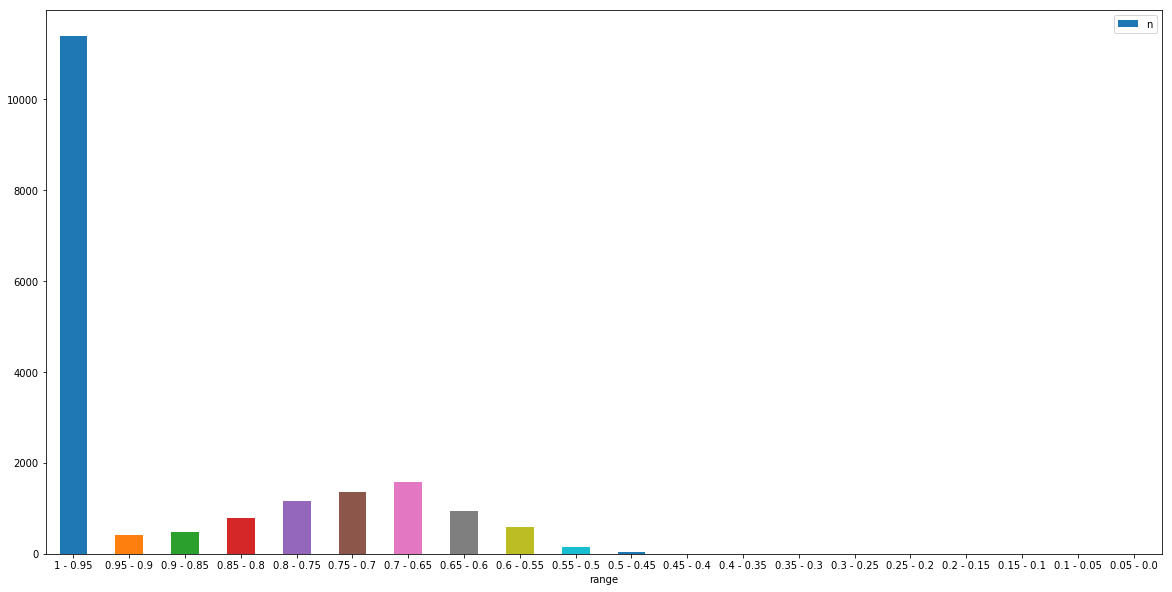

In [17]:
%matplotlib inline
data_sql ='data/data.db'
conn=sqlite3.connect(data_sql)
cur = conn.cursor()
cur.execute('SELECT title, ID_p0, ID_p1, ID_p2, ID_p3, ID_p4, p_max FROM titlematch')
data=cur.fetchall()

df2= pd.DataFrame(sorted(data,key = lambda x: x[-1], reverse=True), columns=['title','ID_p0','ID_p1','ID_p2','ID_p3','ID_p4', 'p_max'])

# 0.05 er Schritte
ranges=[]
upper=1
downer=0.95
while downer>=0:
    ranges.append((str(upper)+' - '+str(downer), len(df2[(df2['p_max'] > downer) & (df2['p_max'] <= upper)])))
    upper=round(upper-0.05,4)
    downer=round(downer-0.05,4)
    
df3= pd.DataFrame(ranges, columns=['range','n'])
df3.plot.bar(x='range', y='n', rot=0, figsize=(20,10))

In [18]:
for ID_p in ['ID_p0','ID_p1','ID_p2','ID_p3','ID_p4']:
    df2[ID_p]=[wiki_raw[ID][0] for ID in df2[ID_p]]

In [19]:
print(len(df2[(df2['p_max'] > 0.8) & (df2['p_max'] <= 0.95)]))
df2[(df2['p_max'] > 0.8) & (df2['p_max'] <= 0.95)][:10]

1692


,title,ID_p0,ID_p1,ID_p2,ID_p3,ID_p4,p_max
11395,The Warlords (2 DVDs),Die Normannen kommen,Der Dieb der Worte,Die Warriors,Wir alle sind verdammt,The Ward,0.95
11396,The Warlords [Blu-ray],Die Normannen kommen,Der Dieb der Worte,Die Warriors,Wir alle sind verdammt,The Ward,0.95
11397,Das Feuerrote Spielmobil : (Das Haus mit der N...,Das feuerrote Spielmobil,Das feuerrote Spielmobil,Das feuerrote Spielmobil,Das feuerrote Spielmobil,Das verbotene Spiel,0.95
11398,Blue Blood - Wer sich in Gefahr begibt...,Blue Bloods – Crime Scene New York,True Blood,Flesh and Blood,Blue Moon (Film),New Blood – Tod in London,0.95
11399,Terminator 2: Tag der Abrechnung - Ultimate Ed...,Terminator 2 – Tag der Abrechnung,Terminator 3 – Rebellion der Maschinen,Terminator 2 – Tag der Abrechnung,Terminator (Film),Terminator (Film),0.95
11400,Ludwig II. - Leben und Tod des Märchenkönigs -...,Ludwig II. (2012),Ludwig II. (1972),Ludwig II. (1972),Ludwig II. (1955),Ludwig II. (2012),0.95
11401,Es war einmal das Leben - Teil 1-6 (6 DVDs),Es war einmal … das Leben,Es war einmal … das Leben,Es war einmal ein Vater,Es war einmal ein König,Es war einmal … der Mensch,0.95
11402,Snowy White - The Way it is ... Live (+ Audio-...,Snow White (2001),Snow White (2005),Schneewittchen (1933),Sydney White – Campus Queen,Snow White (2005),0.95
11403,Flags of our Fathers - Letters from Iwo Jima C...,Flags of Our Fathers,Letters from Iwo Jima,I Am Your Father,Vier Federn (1939),Die vier Federn (2002),0.95
11404,Scott &amp; Huutch,Scott & Huutsch,Scott & Huutsch,Scott & Huutsch,Mascottchen,Der Scout (1994),0.95


In [20]:
print(len(df2[(df2['p_max'] > 0.7) & (df2['p_max'] <= 0.8)]))
df2[(df2['p_max'] > 0.7) & (df2['p_max'] <= 0.8)][:10]

2512


,title,ID_p0,ID_p1,ID_p2,ID_p3,ID_p4,p_max
13087,The Fruit Machine,The Machine (2013),The Machine (2013),The Time Machine (2002),The Machine (2013),Die Zeitmaschine (1960),0.8
13088,Level 42 - At Rockpalast,Level E,Zdf.kulturpalast,Le Bal – Der Tanzpalast,Liebe 47,Black Past,0.8
13089,The Private Life of Henry VIII.,Das Liebesleben der schönen Helena,Das Liebesleben der schönen Helena,Das Privatleben Heinrichs VIII.,Das Privatleben Heinrichs VIII.,The Private Life of the Gannets,0.8
13090,Halloween Horror Blut-Box (Metallbox-Edition/9...,H3 – Halloween Horror Hostel,H3 – Halloween Horror Hostel,H3 – Halloween Horror Hostel,H3 – Halloween Horror Hostel,H3 – Halloween Horror Hostel,0.8
13091,No Angels - When The Angels Swing,Los Ángeles (Film),Engel im Schnee,D·N·Angel,Wir sind keine Engel (1955),Wir sind keine Engel (1989),0.8
13092,Zirkuswelt,Circus-Welt,Zirkusblut,Der Zirkus,Zirkus Renz,Franks Welt,0.8
13093,"Origin - Spirits of the Past (Special Edition,...",I Origins – Im Auge des Ursprungs,Orion (Comic),Original Sin (Film),Organ (Film),Kriegerin,0.8
13094,"Matchball, Folge 04-06",Matchball für die Liebe,Matchball (Fernsehserie),Matchball (Fernsehserie),Michaël Logan,Matchball für die Liebe,0.8
13095,Die Toten Hosen - Friss oder Stirb (3 DVDs),Die Toten leben,Die Toten schweigen (Film),Die Totenliste,Ravenous – Friss oder stirb,Die toten Augen,0.8
13096,Nude Dreamgirls - Die schönsten Traumfrauen de...,Dreamgirls,Die Träumer,Dragon Girls,Nine Queens,Sweet Dreams (1985),0.8


In [21]:
print(len(df2[(df2['p_max'] < 0.7)]))
df2[(df2['p_max'] < 0.7)][:10]

2935


,title,ID_p0,ID_p1,ID_p2,ID_p3,ID_p4,p_max
15985,Sexual Intrigue,Stealing Time,Sexual Healing (Film),Sexual Quest,Die Frosch-Intrige,Sexual Healing (Film),0.69
15986,Cat Stevens - Majikat: Earth Tour 1976,Straßen der Weltstadt,Beat Street,Satin Steel,Nightwatch – Nachtwache,Adam & Steve,0.69
15987,Was geht - Die Fantastischen Vier,"Was geht, Noah?",Last Night (1998),Last Night (2010),Die phantastische Reise,Was bleibt (2012),0.69
15988,AC/DC - And Then There Was Rock,And Then There Were None,Ein Unbekannter rechnet ab,And Then There Were None,Das letzte Wochenende,Das letzte Wochenende,0.69
15989,LazyTown Vol. 1 - Willkommen in LazyTown,LazyTown,Willkommen in Marwen,Almanya – Willkommen in Deutschland,Almanya – Willkommen in Deutschland,Willkommen im Wayne,0.69
15990,Bad Religion - Live at the Palladium (Los Ange...,Bad Reputation,Dandelion – Eine Liebe in Idaho,Geheimbund Schwarze Legion,Bad Neighbors,Black Out – Anatomie einer Leidenschaft,0.69
15991,Lauryn Hill - MTV Unplugged,Haunted Hill,Sarah & Harley – Eine Freundschaft für immer,Fanny Hill (1983),Fanny Hill (1964),Die schwarzen Zombies von Sugar Hill,0.69
15992,Frank Sinatra - A Man And His Music + Ella + J...,Frank Riva,Franklin – Eine Schildkröte erobert die Welt,Frankensteins Kater,Frank Film,Frankensteins Tante (Fernsehserie),0.69
15993,Kesse Teens - Die erste Liebe,Besser lesen,Besser lesen,My Girl – Meine erste Liebe,Aquamarin – Die vernixte erste Liebe,Besser Reisen,0.69
15994,Ballet Class - Intermediate And Advanced With ...,Basket Case – Der unheimliche Zwilling,Alles erlaubt – Eine Woche ohne Regeln,Ballet Shoes (Film),The Class,Ballers,0.69


In [22]:
(len(df2[(df2['p_max'] > 0.95) & (df2['p_max'] > 0.95)]))

11395

In [23]:
(len(df2[(df2['p_max'] >= 0.95) & (df2['p_max'] >= 0.95)]))

11498

In [24]:
df2[(df2['p_max'] < 0.5) & (df2['p_max'] < 0.5)]

,title,ID_p0,ID_p1,ID_p2,ID_p3,ID_p4,p_max
18896,Autour du Blues meets Larry Carlton &amp; R. Ford,Sweetheart (1992),Ein einziger Augenblick,Mein Freund Winnetou,Fade to Black – Die schönen Morde des Eric Bin...,Undercover Blues – Ein absolut cooles Trio,0.49
18897,Robin Gibb with the Neue Philharmonie Frankfur...,Ronks – Keine Steinzeit ohne Alien!,Verliebt in einen Fremden,Kindertransport – In eine fremde Welt,Der Hobbit: Eine unerwartete Reise,"Die Geschichte vom Teddy, den niemand wollte",0.49
18898,Airbus A380 Vol.2 PRODUKTION- FLIGHTTESTS-WORD...,"Buster Keaton, der Filmreporter",Abschied ist ein leises Wort,Last Flight To Abuja,Last Flight To Abuja,Airborne – Flügel aus Stahl,0.49
18899,From Madonna And Gwyneth's Personal Trainer - ...,Man nannte es den großen Krieg,Schmeiß’ die Mama aus dem Zug!,Die Reise des Personalmanagers,Der Mann von der Insel Man,Der Sohn des rosaroten Panthers,0.49
18900,Hilary Hahn &amp; Gustavo Dudamel - Geburtstag...,Harry meint es gut mit dir,Hilary & Jackie,Eva und Adam – Vier Geburtstage und ein Fiasko,Tarzans Kampf ums Leben,Das Haus am Eaton Place,0.49
18901,Aynsley Lister &amp; Erja Lyytinen &amp; Ian P...,Asterix – Operation Hinkelstein,Metro – Verhandeln ist reine Nervensache,Klemperer – Ein Leben in Deutschland,Die Strategie der Schnecke,Klemperer – Ein Leben in Deutschland,0.49
18902,Studiofotografie ~ Aktfotografie im Fotostudio,Street Fighter II – The Animated Movie,Die gewaltigen Sieben,Violent Cop,Umi Monogatari – Anata ga Ite Kureta Koto,Ungeschminkt (Fernsehsendung),0.49
18903,PilotsEYE.tv. Cockpitflight Lufthansa Airbus A...,Zurück auf die Straßen von San Francisco,Die Straßen von San Francisco,The Big One – Das große Beben von San Francisco,Der Boß von San Francisco,Atomalarm in San Francisco,0.48
18904,HANK WILLIAMS I'll Never Get Out Of This World...,Unendliche Weiten – Ein Raumschiff verändert d...,Was kommt danach…?,Fremd in der Welt,Was kommt danach…?,Fremd in der Welt,0.48
18905,Joe Zawinul &amp; The Zawinul Syndicate - Live...,Josie and the Pussycats (Film),Das Geheimnis von Chateau Richmond,Barbara’s Baby – Omen III,Die Eule und das Kätzchen (1970),So einfach ist die Liebe nicht,0.48
